# Highlight method differences on the 330/390 min time point pair (ABpxp lineage)

- Visualize the difference in ancestor & descendant error
- zoom into one cluster and highlight the difference in the actual couplings.

## Preliminaries

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import moscot as mc
import moscot.plotting as mtp
from anndata import AnnData
import matplotlib.colors as mcolors

import moslin_utils as mu
from moslin_utils.constants import DATA_DIR, FIG_DIR, TIME_KEY

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

Print the moscot version. 

In [3]:
mc.__version__

'0.3.4'

### Dependencies

This notebook depends on [ML_2024-03-11_prepare_data.ipynb](ML_2024-03-11_prepare_data.ipynb) and on [ML_2024-03-11_compute_couplings.ipynb](ML_2024-03-11_compute_couplings.ipynb). 

### Set up paths

Define the paths for data and figures

In [4]:
FIG_DIR = FIG_DIR / "packer_c_elegans" / "zoom_in"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

### Set global parameters

In [6]:
DPI_SAVE = 250

scv.settings.set_figure_params(
    "scvelo",
    dpi_save=DPI_SAVE,
    dpi=80,
    transparent=True,
    fontsize=20,
    color_map="viridis",
)
scv.settings.plot_prefix = ""

In [7]:
# should figures just be displayed or also saved?
save_figure = False
RANDOM_STATE = 0

In [8]:
EARLY_TP, LATE_TP = 330, 390
LINEAGE_INFO = "ABpxp"
random_state = 0

### Define utility functions

### Load and preprocess the data

Load AnnData objects, created in previous notebooks. 

In [9]:
# import the raw data, to re-compute the couplings
adata = sc.read(DATA_DIR / "ML_2024-06-09_c_elegans_prep.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'

Download the C. elegans lineage tree [(Packer et al., Science 2019)](https://www.science.org/doi/10.1126/science.aax1971) from [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). Subset to the ABpxp lineage, preprocess the data, compute PCA, and write the lineage tree to `.uns`. 

In [10]:
_, full_reference_tree = mc.datasets.c_elegans(DATA_DIR / "c_elegans")

Subset to the ABpxp lineage

In [11]:
mask = adata.obs["subset"] == LINEAGE_INFO
adata = adata[mask].copy()
adata

AnnData object with n_obs × n_vars = 7356 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'

Preprocess

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.pca(adata)

Create lineage trees

In [13]:
rng = np.random.RandomState(RANDOM_STATE)
trees = {}
for batch_time in adata.obs[TIME_KEY].cat.categories:
    print(f"Creating tree for batch time {batch_time}")
    seed = rng.randint(0, 2**16 - 1)
    trees[batch_time] = mu.ul.create_lineage_tree(
        adata, batch_time=batch_time, reference_tree=full_reference_tree, seed=seed
    )

adata.uns["trees"] = trees

Creating tree for batch time 130
Creating tree for batch time 170
Creating tree for batch time 210
Creating tree for batch time 270
Creating tree for batch time 330
Creating tree for batch time 390
Creating tree for batch time 450
Creating tree for batch time 510
Creating tree for batch time 580
Creating tree for batch time 650
Creating tree for batch time 75
Creating tree for batch time 700


In addition, import the grid search results to inform our choice of hyperparematers. The results of our gridsearch are included in this repositroy in `data/packer_c_elegans`. 

In [14]:
grid_df = pd.read_csv(DATA_DIR / "ML_2024-06-05_celegans_precise_and_abpxp.csv", index_col=0)

### Visualize in an embedding

For convenience, rename the UMAP. 

In [15]:
adata.obsm["X_umap"] = adata.obsm["X_umap_abpxp"].copy()

Rearrange the order in which clusters appear

In [16]:
adata = mu.ul.sort_clusters(adata)

Show in the UMAP. 

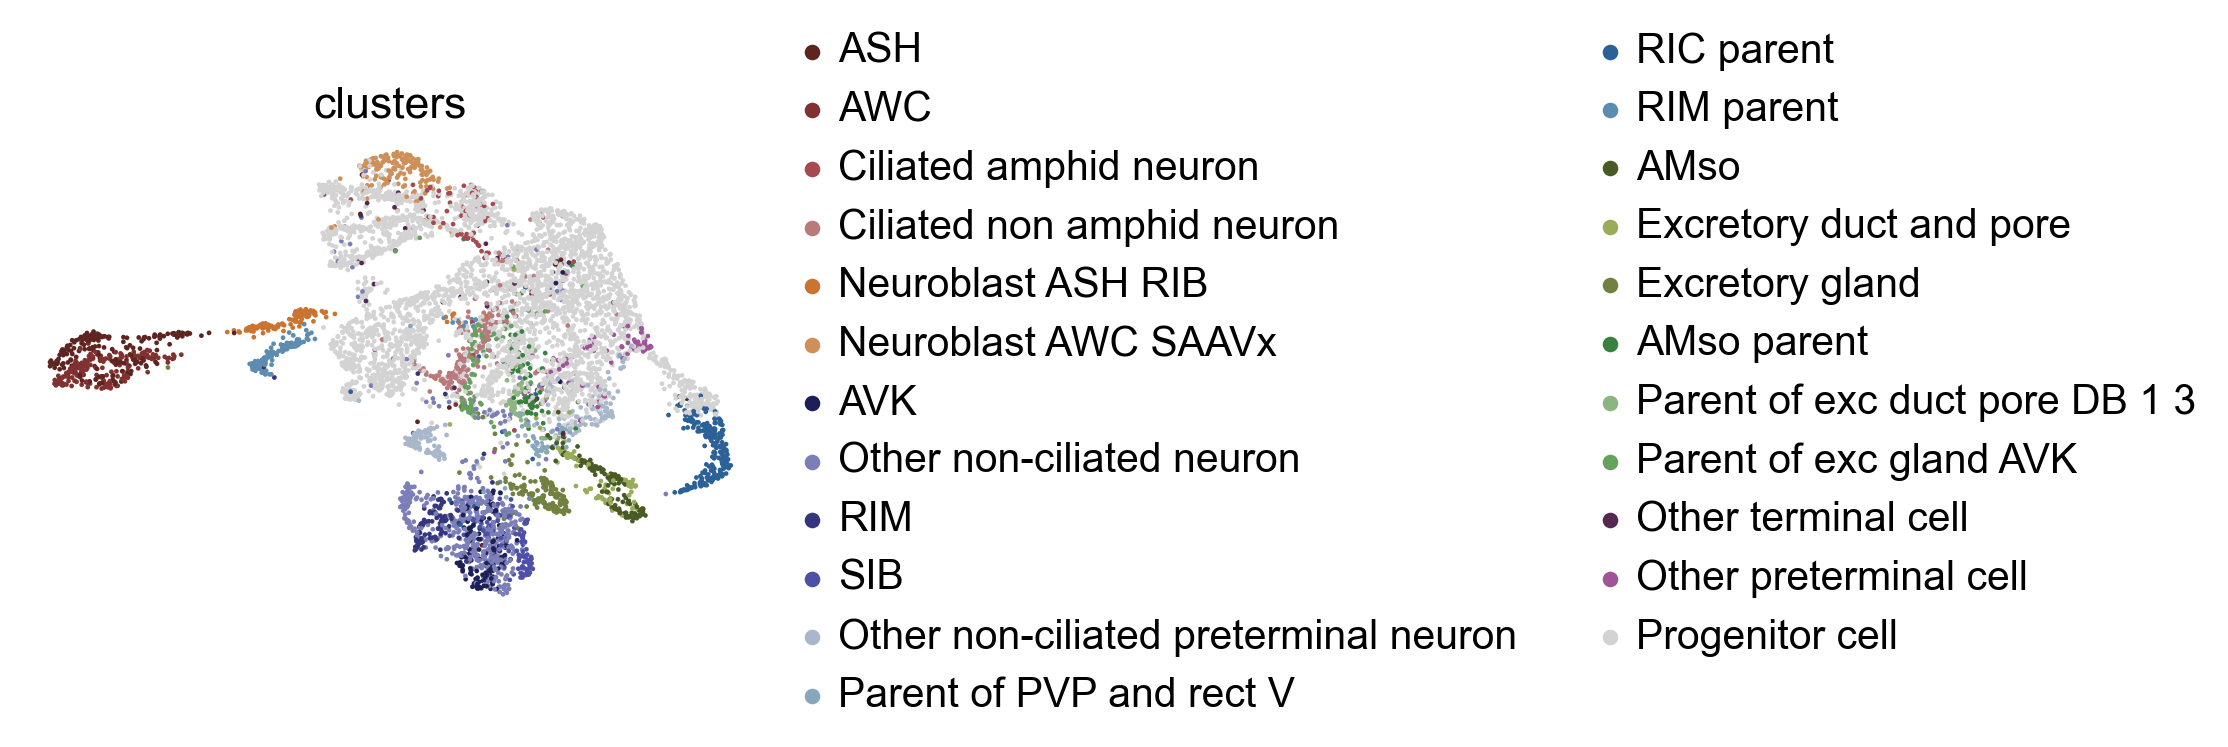

In [17]:
scv.pl.scatter(adata, c=["clusters"], legend_loc="right")

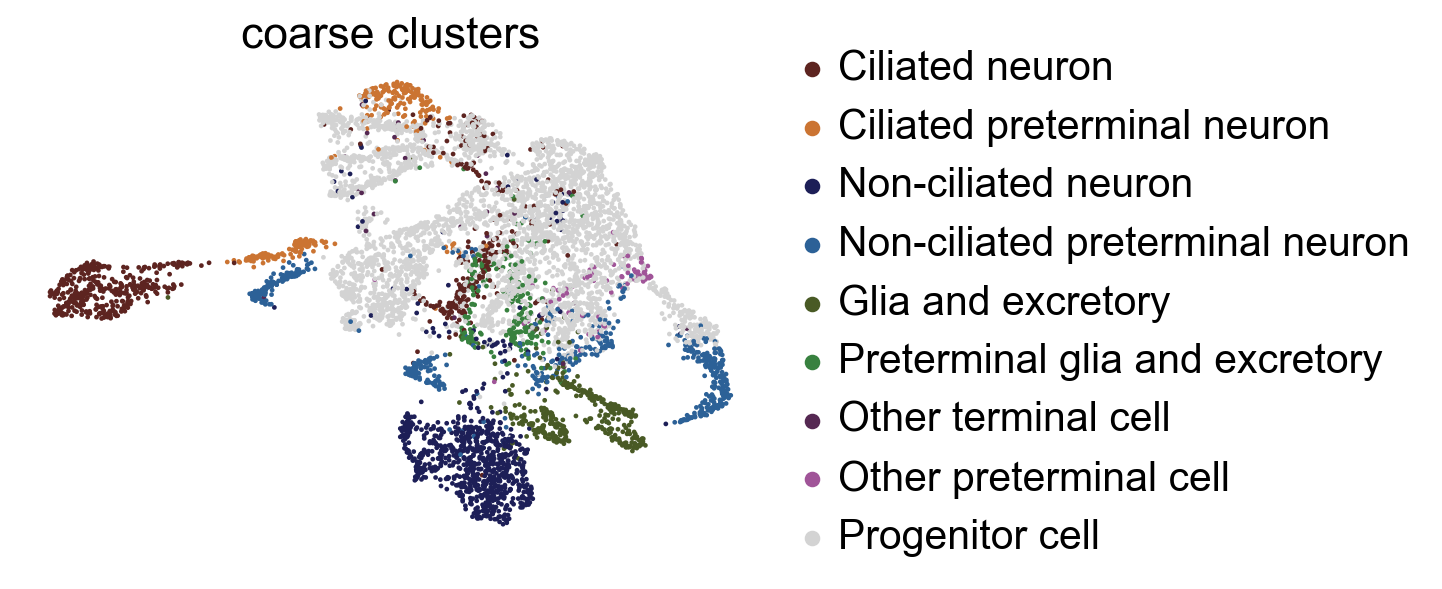

In [18]:
scv.pl.scatter(adata, c=["coarse_clusters"], legend_loc="right")

## Compute the couplings

### Run all methods

In [19]:
methods = np.unique(grid_df["kind"])
methods

array(['GW', 'LineageOT', 'W', 'moslin'], dtype=object)

In [20]:
# prepare results dict
results = {}

# iterate over all methods
for method in methods:
    print(f"Running method {method}")
    hyper_df = mu.ul.get_best_runs(
        df=grid_df, lineage_info=LINEAGE_INFO, group_key="kind", group=method, converged=True
    )

    # extract hyperparameters from gridsearch results
    params = hyper_df.loc[hyper_df["tp"] == f"{EARLY_TP}-{LATE_TP}"]
    alpha = params["alpha"].values[0]
    epsilon = params["epsilon"].values[0]
    scale_cost = params["scale_cost"].values[0]
    max_inner_iterations = params["max_inner_iterations"].values[0]

    # print these parameters and run moslin
    print(f"{EARLY_TP=}, {LATE_TP=}, {epsilon=}, {alpha=} {scale_cost=} {max_inner_iterations=} {method=}")

    # run the corresponding method
    if method in ["moslin", "W", "GW"]:
        prob, pred, conv, gt = mu.tl.benchmark_moscot(
            adata=adata,
            early_time=EARLY_TP,
            late_time=LATE_TP,
            alpha=alpha,
            epsilon=epsilon,
            scale_cost=scale_cost,
            max_inner_iterations=int(max_inner_iterations),
            reorder_clusters=True,
        )
    elif method == "LineageOT":
        pred, conv, gt = mu.tl.benchmark_lot(
            adata=adata,
            early_time=EARLY_TP,
            late_time=LATE_TP,
            epsilon=epsilon,
            scale_cost=scale_cost,
        )
        prob = None
    else:
        raise ValueError(f"Unrecognized method: {method}")

    # make sure this converged
    assert conv, f" Method {method} did not converge. "

    # compute early and late errors
    early_cost = gt.cost(pred, late=False)
    late_cost = gt.cost(pred, late=True)
    mean_error = (early_cost + late_cost) / 2
    print(f"{mean_error=}")

    # save the results
    results[method] = {
        "coupling_matrix": pred,
        "converged": conv,
        "mean_error": mean_error,
        "prob": prob,
        "ground_truth": gt,
    }

Running method GW
Removing 0/30 not converged runs.
EARLY_TP=330, LATE_TP=390, epsilon=0.001, alpha=1.0 scale_cost='mean' max_inner_iterations=30000.0 method='GW'
joint_attr = None
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1874, 855)].                                   


/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -2.821907406636015e-07
  warnings.warn(("Expanded coupling not computed correctly. " +


mean_error=0.38395255759832037
Running method LineageOT
Removing 0/30 not converged runs.
EARLY_TP=330, LATE_TP=390, epsilon=0.05, alpha=nan scale_cost='mean' max_inner_iterations=nan method='LineageOT'
mean_error=0.5682370008986117
Running method W
Removing 2/30 not converged runs.
EARLY_TP=330, LATE_TP=390, epsilon=0.05, alpha=0.0 scale_cost='mean' max_inner_iterations=30000.0 method='W'
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1874, 855)].                                   


/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.6476260497055861e-06
  warnings.warn(("Expanded coupling not computed correctly. " +
/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.0382336764758193e-06
  warnings.warn(("Expanded coupling not computed correctly. " +


mean_error=0.6239467217783616
Running method moslin
Removing 10/240 not converged runs.
EARLY_TP=330, LATE_TP=390, epsilon=0.001, alpha=0.98 scale_cost='mean' max_inner_iterations=30000.0 method='moslin'
joint_attr = {'attr': 'obsm', 'key': 'X_pca'}
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1874, 855)].                                   


/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.1897645890712738e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 8.319148037116975e-08
  warnings.warn(("Expanded coupling not computed correctly. " +


mean_error=0.3155727683083822


Make sure all ground-truth couplings are actually the same

In [21]:
assert (results["GW"]["ground_truth"].coupling == results["W"]["ground_truth"].coupling).all(), "Mismatch for GW vs. W"
assert (
    results["W"]["ground_truth"].coupling == results["LineageOT"]["ground_truth"].coupling
).all(), "Mismatch for W vs. LineageOT"
assert (
    results["LineageOT"]["ground_truth"].coupling == results["moslin"]["ground_truth"].coupling
).all(), "Mismatch for LineageOT vs. moslin"
assert (
    results["moslin"]["ground_truth"].coupling == results["GW"]["ground_truth"].coupling
).all(), "Mismatch for moslin vs. GW"

Make sure all problem AnnData's are actually the same (recall we don't get this for LineageOT). 

In [22]:
assert (results["GW"]["prob"].adata.obs_names == results["W"]["prob"].adata.obs_names).all(), "Mismatch for GW vs. W"
assert (
    results["W"]["prob"].adata.obs_names == results["moslin"]["prob"].adata.obs_names
).all(), "Mismatch for W vs. LineageOT"
assert (
    results["moslin"]["prob"].adata.obs_names == results["GW"]["prob"].adata.obs_names
).all(), "Mismatch for moslin vs. GW"

Designate a ground-truth coupling, and an AnnData object to continue with (they are all the same). 

In [23]:
gt = results["moslin"]["ground_truth"]
adata_mos = results["moslin"]["prob"].adata

### Look into embeddings

Let's look into the distribution over cell types at either time point

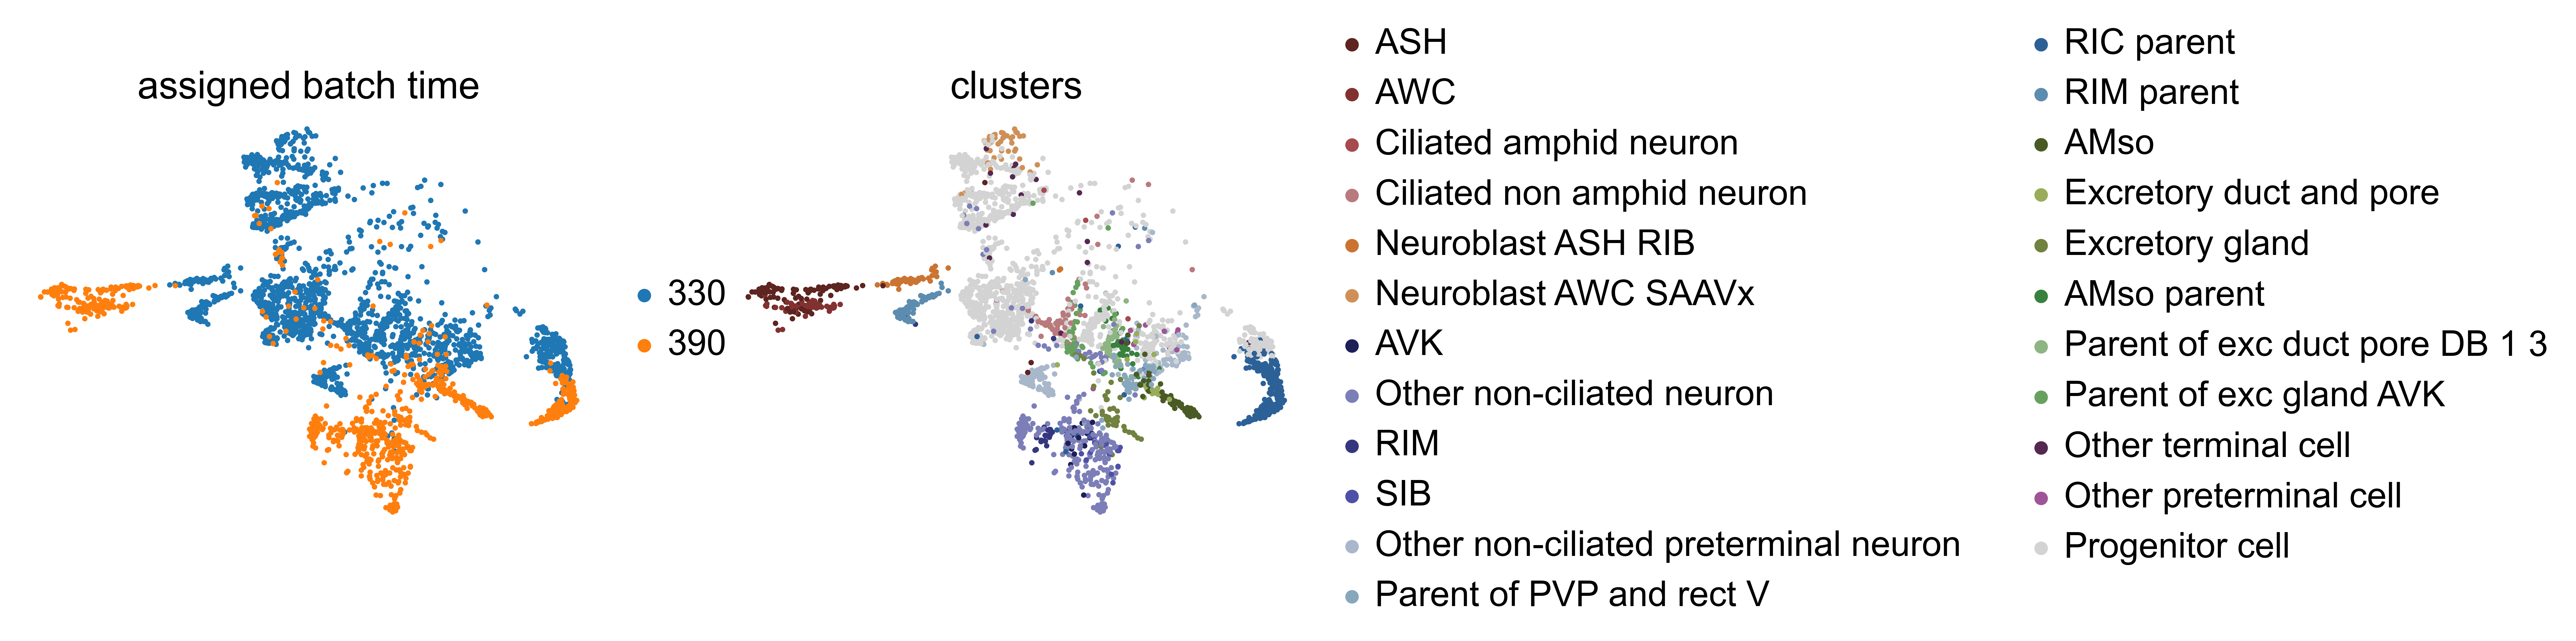

In [24]:
# get early and late representations
early_mask = adata_mos.obs[TIME_KEY] == EARLY_TP
late_mask = adata_mos.obs[TIME_KEY] == LATE_TP

fig_kwargs = {}
if save_figure:
    fig_kwargs["save"] = "umap_330_390_clusters.pdf"

scv.pl.scatter(adata_mos, c=[TIME_KEY, "clusters"], legend_loc="right", dpi=DPI_SAVE, **fig_kwargs)

Show pie charts

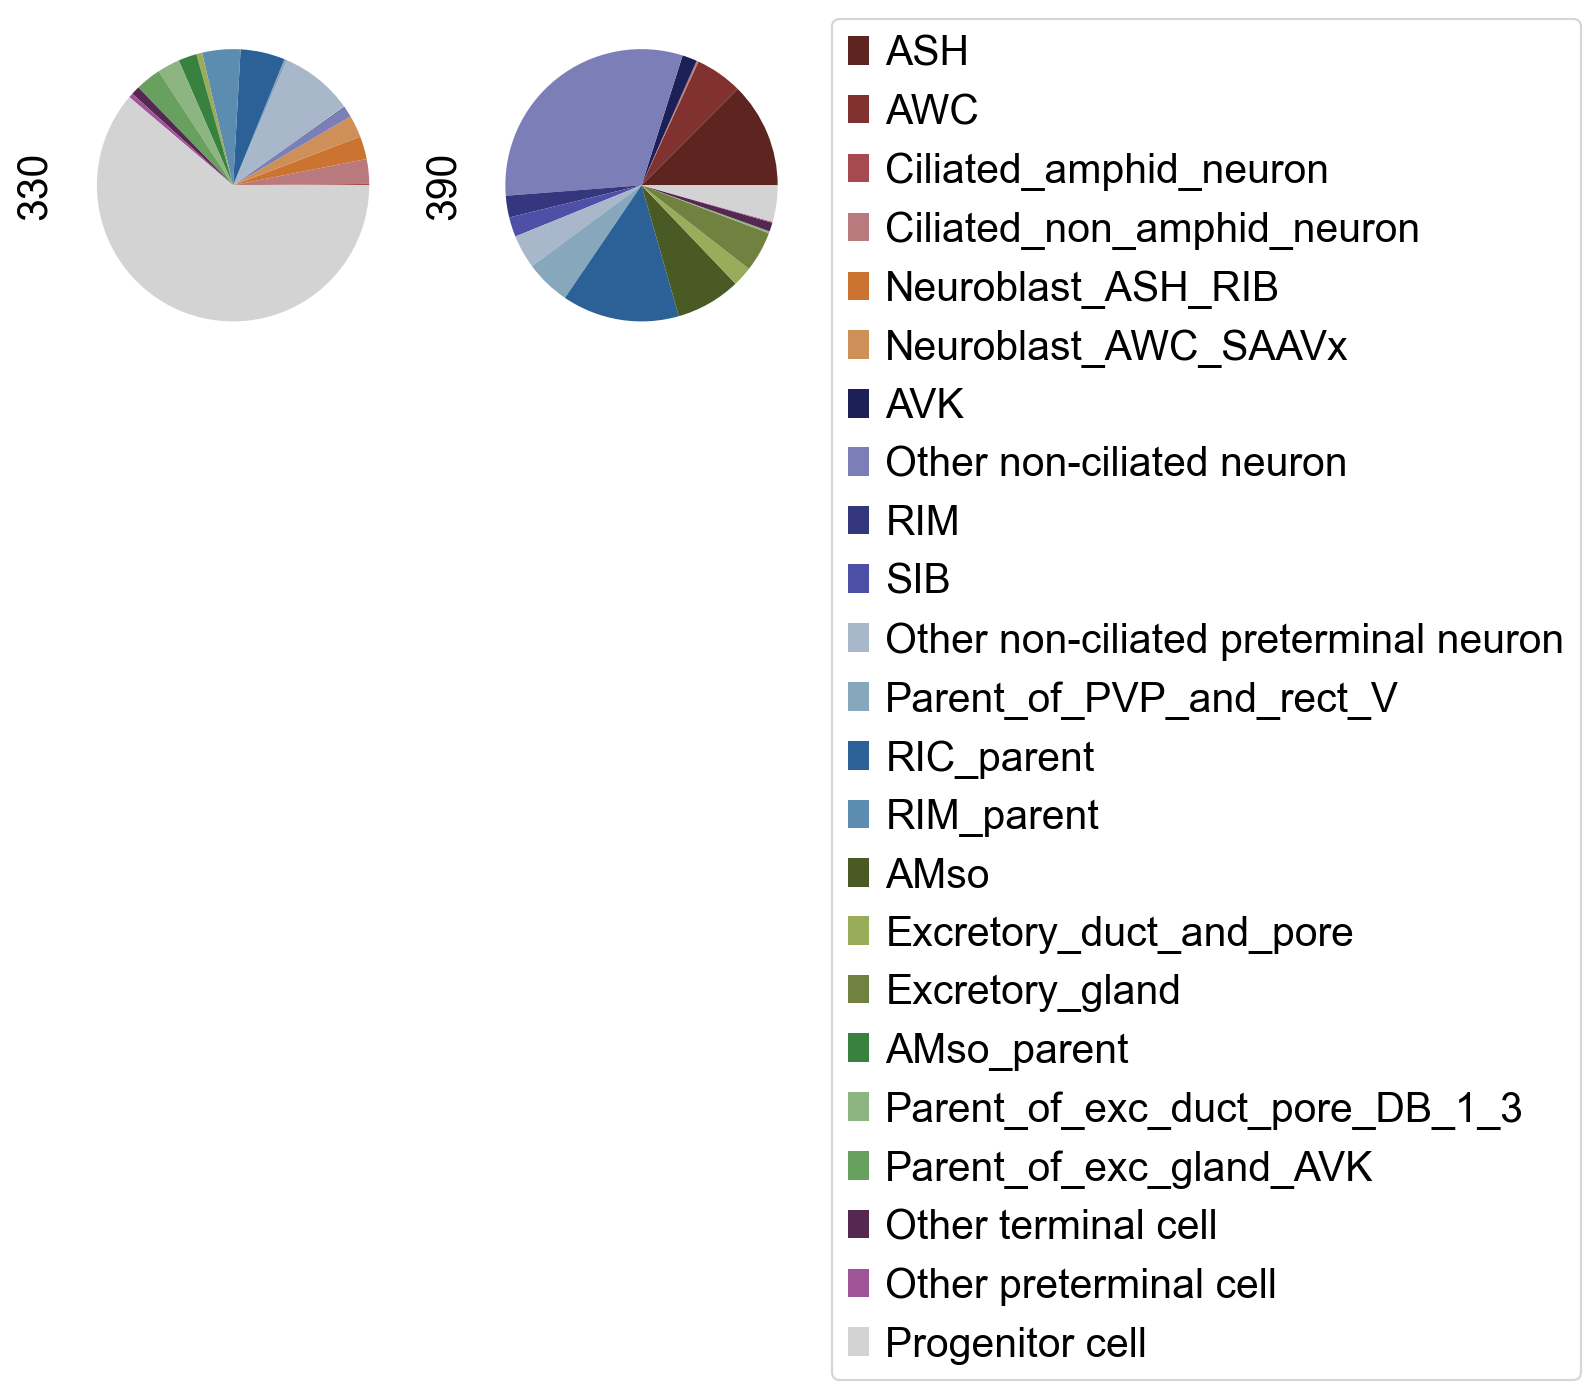

In [25]:
df = adata_mos.obs.groupby(["clusters", TIME_KEY]).size().unstack()
ax = df.plot.pie(subplots=True, labels=None, legend=None, colors=adata_mos.uns["clusters_colors"])

plt.legend(df.index, bbox_to_anchor=(1, 1.05))

plt.show()

## Visualize ancestor distributions

### Prepare GT and LineageOT problems

Create dummy moscot problems for GT and LineageOT, to facility easy plotting. 

In [26]:
prob_lot, _, _, _ = mu.tl.benchmark_moscot(
    adata=adata,
    early_time=EARLY_TP,
    late_time=LATE_TP,
    alpha=0,
    epsilon=0.5,
    scale_cost="mean",
    max_inner_iterations=100,
    reorder_clusters=True,
)

prob_gt, _, _, _ = mu.tl.benchmark_moscot(
    adata=adata,
    early_time=EARLY_TP,
    late_time=LATE_TP,
    alpha=0,
    epsilon=0.5,
    scale_cost="mean",
    max_inner_iterations=100,
    reorder_clusters=True,
)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1874, 855)].                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1874, 855)].                                   


Next, take the solved couplings and insert them into the dummy problems. 

In [27]:
prob_lot[330, 390].set_solution(results["LineageOT"]["coupling_matrix"], overwrite=True)

prob_gt[330, 390].set_solution(gt.coupling, overwrite=True)

BirthDeathProblem[stage='solved', shape=(1874, 855)]

Verify that this worked

In [28]:
assert (
    results["LineageOT"]["coupling_matrix"] == prob_lot[330, 390].solution.transport_matrix
).all(), "Setting the LOT solution failed"

assert (gt.coupling == prob_gt[330, 390].solution.transport_matrix).all(), "Setting the ground truth solution failed"

Write these to the results dict

In [29]:
results["LineageOT"]["prob"] = prob_lot
results["gt"] = {"prob": prob_gt}

### Show in embeddings

Change the order of entries in the results dict. 

In [30]:
new_order = ["gt", "LineageOT", "W", "GW", "moslin"]
results = {key: results[key] for key in new_order}

Visualize where different methods predict RIM cells to come from. 

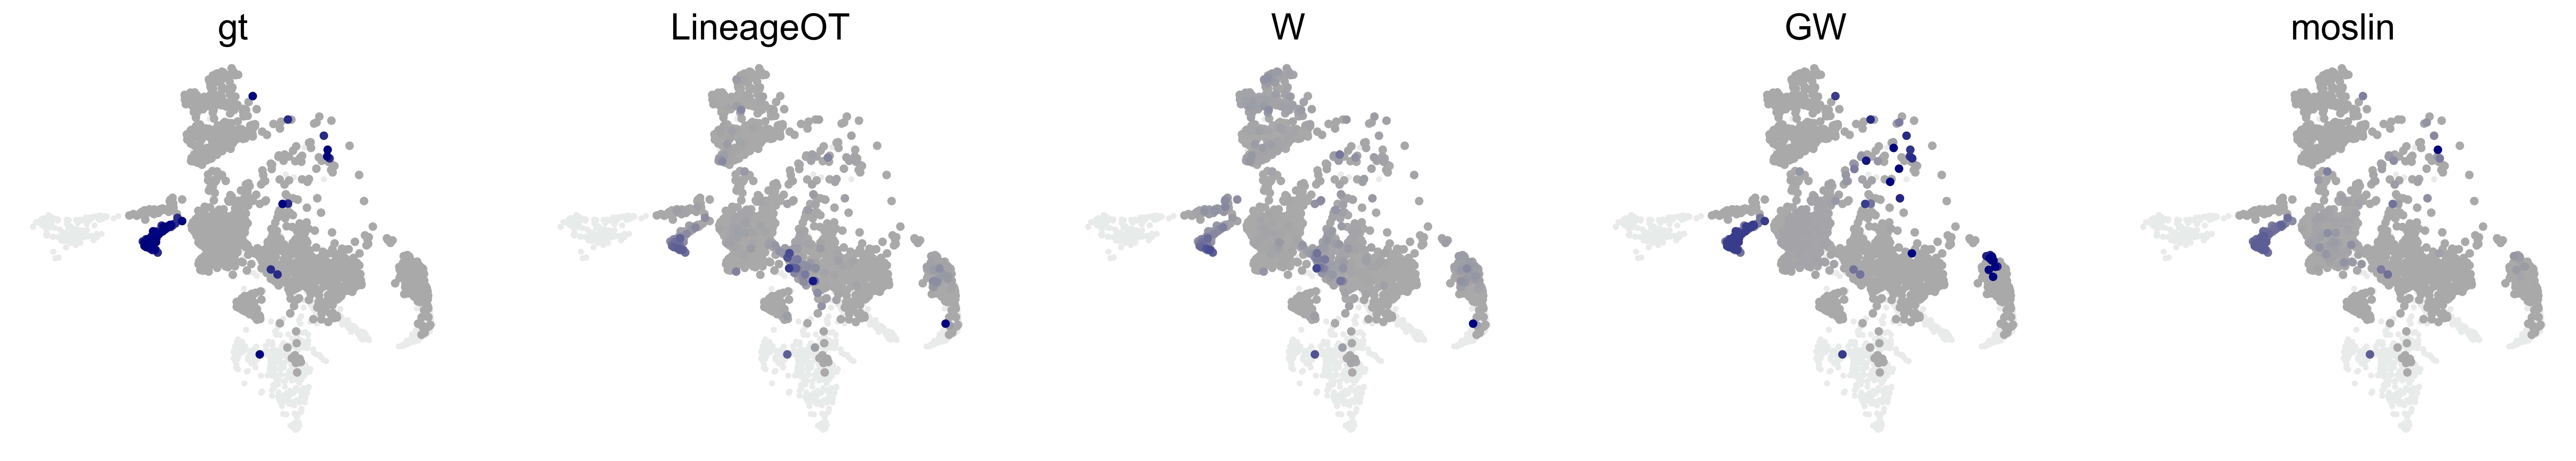

In [31]:
# define the target state
tgt_state = "RIM"

# initialize an empty DataFrame for the results
adata_src = results["moslin"]["prob"][EARLY_TP, LATE_TP].adata_src.copy()
pull_df = pd.DataFrame(index=adata_src.obs_names.copy(), columns=results.keys())

# set up figure and axes
n_panels = len(results)
fig, axes = plt.subplots(1, n_panels, figsize=(5 * n_panels, 4), dpi=DPI_SAVE)

# iterate over methods, use their solved problems to compute the pull of the target state
for i, (method, value_dict) in enumerate(results.items()):
    # get the corresponpding problem
    ot_problem = value_dict["prob"]

    # compute the pull distribution
    ot_problem.pull(source=EARLY_TP, target=LATE_TP, data="clusters", subset=tgt_state)

    # extract it from the problem
    pull_df[method] = ot_problem[EARLY_TP, LATE_TP].adata_src.obs["pull"].copy()

    # plot in the umap
    axes[i] = mtp.pull(
        ot_problem,
        time_points=[330],
        basis="umap",
        ax=axes[i],
        return_fig=True,
        title=[f"{method}"],
        frameon=False,
        colorbar_loc=None,
    )

# insert into an AnnData object
pdata = AnnData(X=pull_df, obs=adata_src.obs.copy())

# put cluster information into the DataFrame
pull_df["clusters"] = adata_src.obs["clusters"].copy()

if save_figure:
    plt.savefig(FIG_DIR / "umap_ancestor_error.pdf", bbox_inches="tight")

Pie charts over the ancestor mass distribution

/var/folders/j6/fcqzqhwj6y7b1nzw3241zgjw0000gr/T/ipykernel_68407/3496562185.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.plot.pie(subplots=True, labels=None, legend=None, colors=adata_src.uns["clusters_colors"], ax=ax)


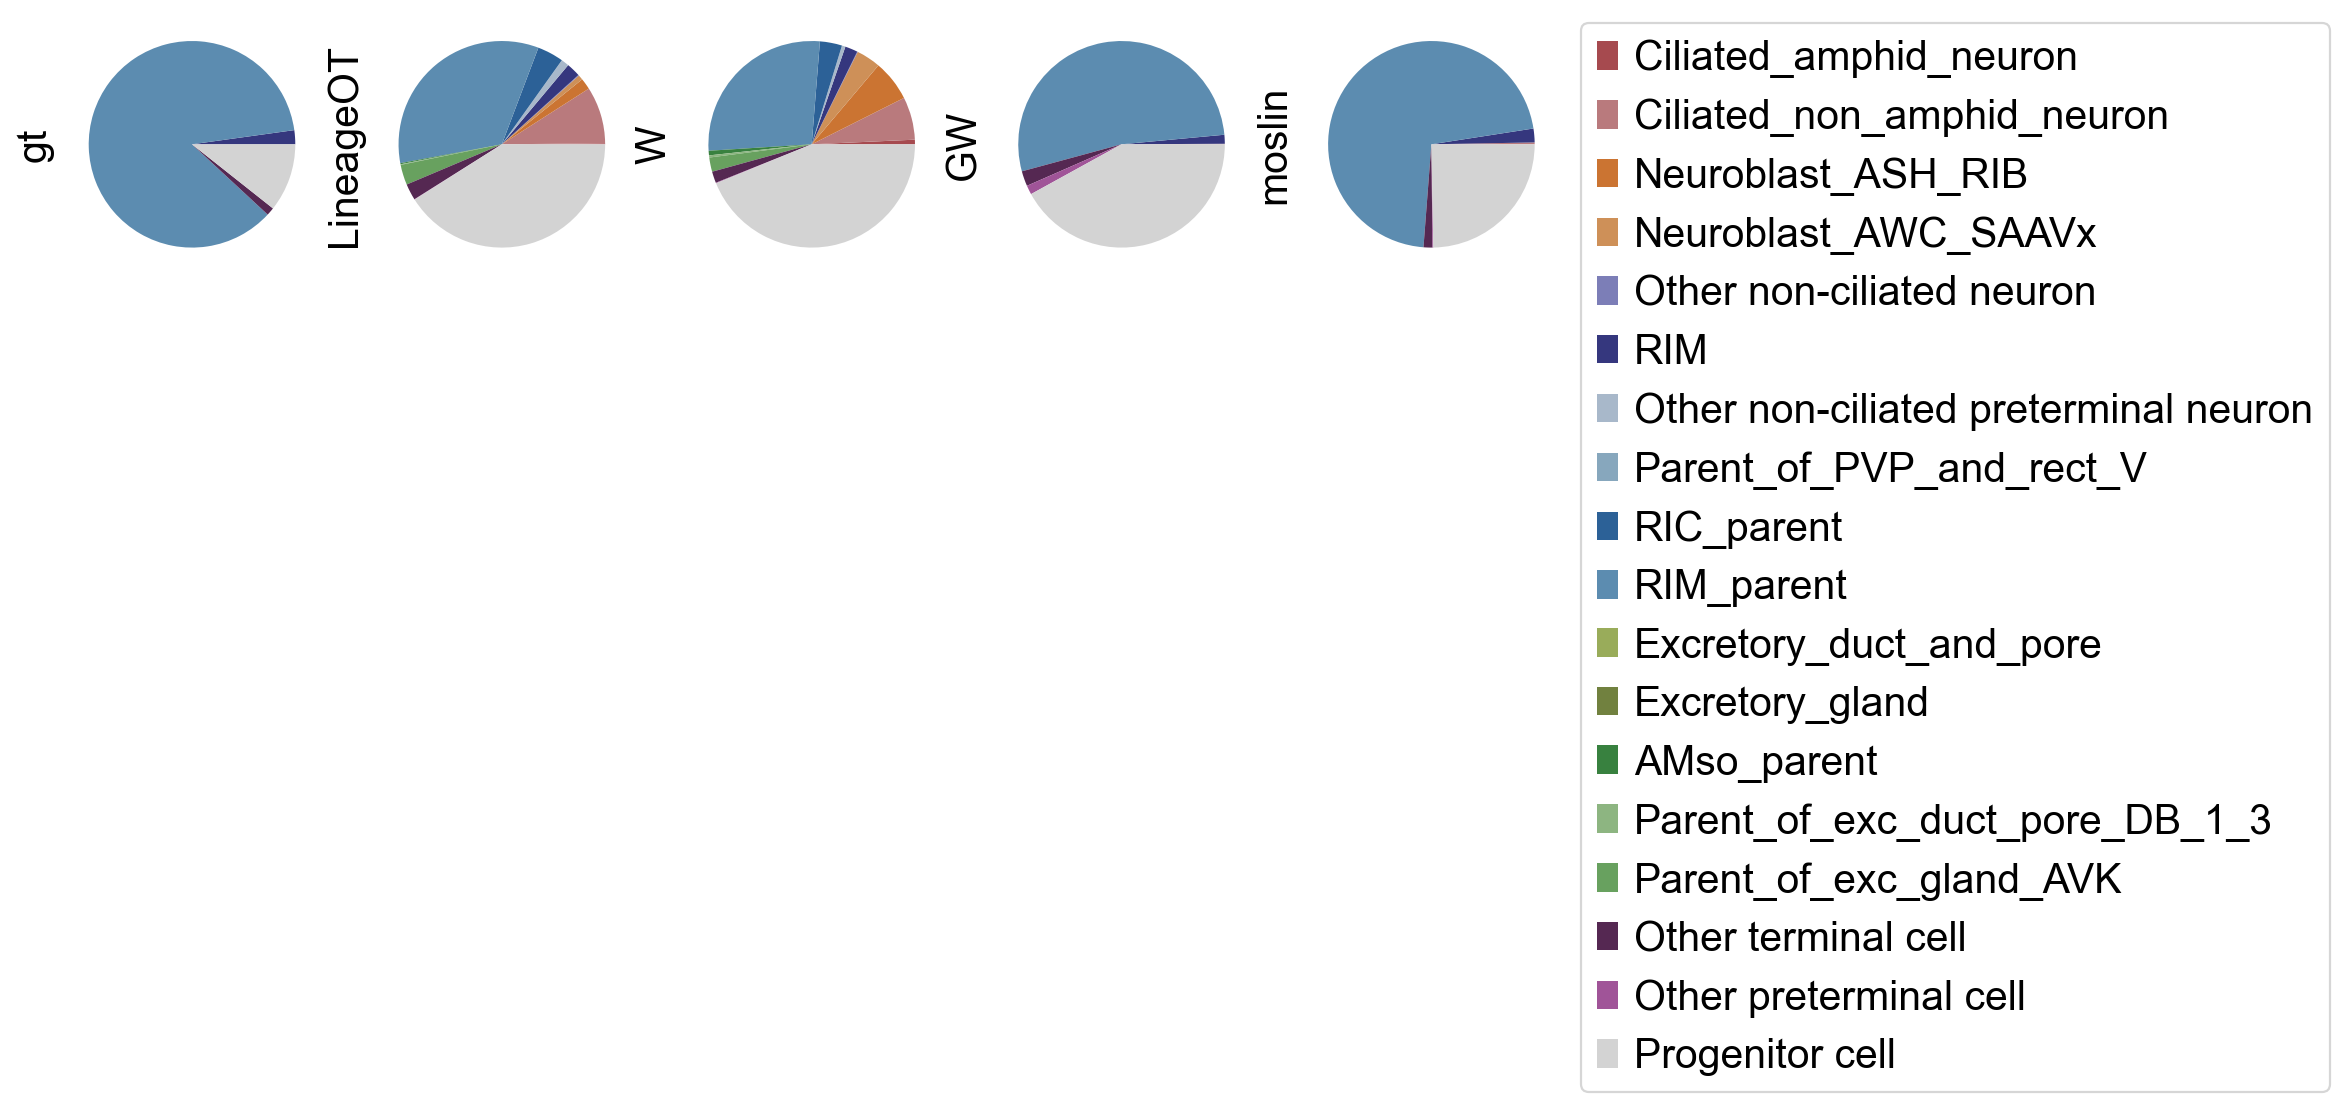

In [32]:
fig, ax = plt.subplots(figsize=(12, 3))

df = pull_df.groupby("clusters").sum()
df.plot.pie(subplots=True, labels=None, legend=None, colors=adata_src.uns["clusters_colors"], ax=ax)

plt.legend(df.index, bbox_to_anchor=(1.0, 1.05))

if save_figure:
    plt.savefig(FIG_DIR / "pie_charts_ancestor_distribution.pdf", bbox_inches="tight")

plt.show()

### Compute ancestor/descendant errors

Compute error metrics for LineageOT. 

In [33]:
anc_lot, des_lot = mu.ul.compute_errors(results["LineageOT"]["coupling_matrix"], gt, scale_by_marginal=False)

100%|██████████| 1874/1874 [00:07<00:00, 267.17it/s]


Compute error metrics for moslin. 

In [34]:
anc_mos, des_mos = mu.ul.compute_errors(results["moslin"]["coupling_matrix"], gt, scale_by_marginal=False)

100%|██████████| 1874/1874 [00:04<00:00, 387.83it/s]


Write the resulting errors, and differences in erorrs, back to AnnData

In [35]:
# write the error for LineageOT
adata_mos.obs["lot_error"] = anc_lot + des_lot  # assumes t1 < t2 always
adata_mos.obs["lot_early_error"] = np.nan
adata_mos.obs.loc[adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == LATE_TP)], "lot_early_error"] = anc_lot
adata_mos.obs["lot_late_error"] = np.nan
adata_mos.obs.loc[adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == EARLY_TP)], "lot_late_error"] = des_lot

# write the error for moslin
adata_mos.obs["moslin_error"] = anc_mos + des_mos  # assumes t1 < t2 always
adata_mos.obs["moslin_early_error"] = np.nan
adata_mos.obs.loc[adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == LATE_TP)], "moslin_early_error"] = anc_mos
adata_mos.obs["moslin_late_error"] = np.nan
adata_mos.obs.loc[adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == EARLY_TP)], "moslin_late_error"] = des_mos

# compute the difference in errors, for ancestors and descendants.
adata_mos.obs["diff_error"] = adata_mos.obs["lot_error"] - adata_mos.obs["moslin_error"]
adata_mos.obs["diff_early_error"] = adata_mos.obs["lot_early_error"] - adata_mos.obs["moslin_early_error"]
adata_mos.obs["diff_late_error"] = adata_mos.obs["lot_late_error"] - adata_mos.obs["moslin_late_error"]

## Visualize the zoom in

### Visualize the ancestor and descendant error

Plot the actual error differences in the UMAP. 

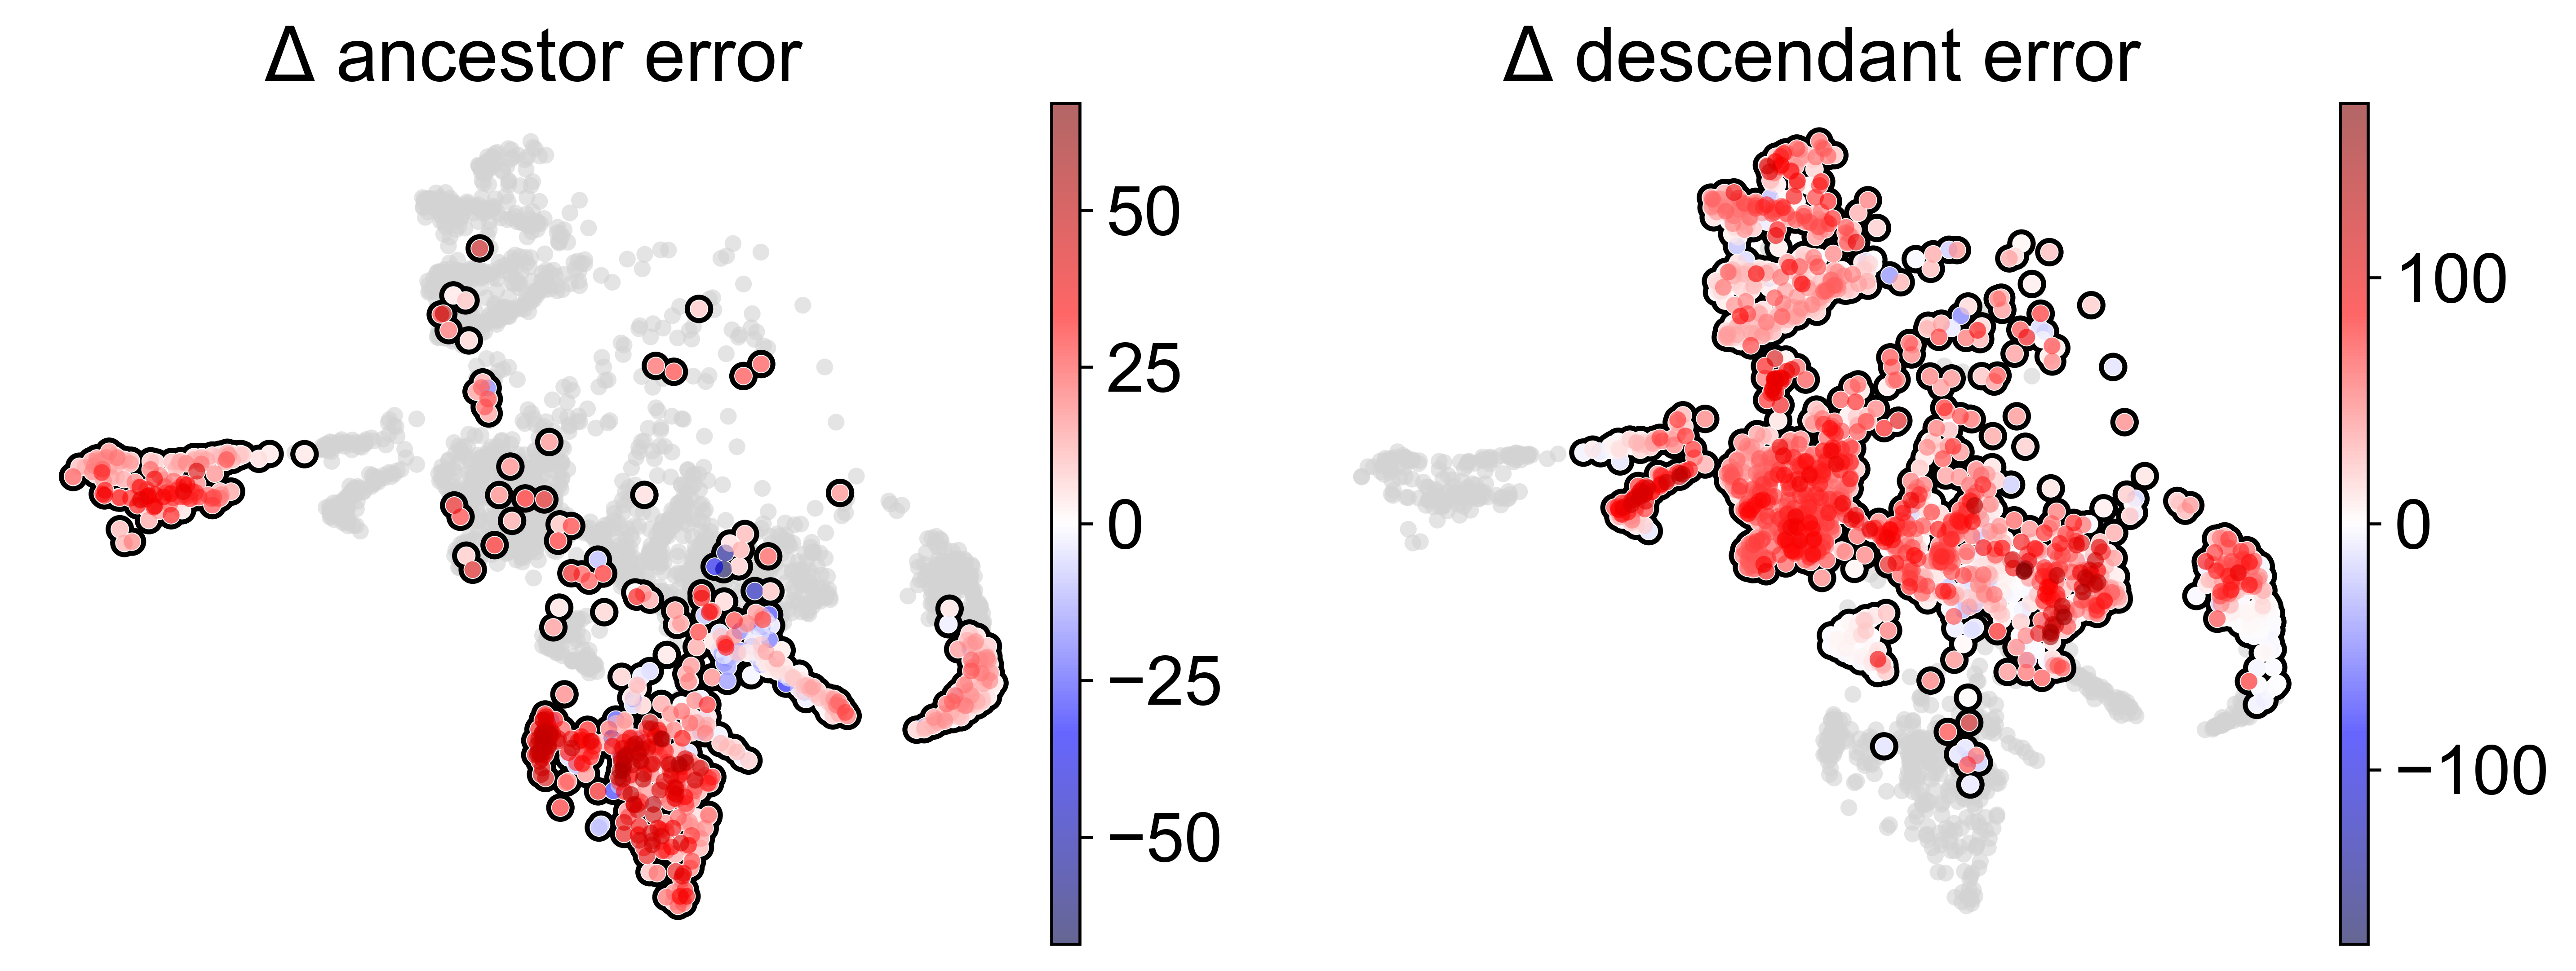

In [36]:
fig_kwargs = dict(early_tp=EARLY_TP, late_tp=LATE_TP)
if save_figure:
    fig_kwargs["save"] = "umap_delta_error.pdf"

fig = mu.pl.plot_ancestor_descendant_error(adata_mos, **fig_kwargs)

### Visualize coupling for target population

I would like to focus on the `RIM_parent` population: 

In [37]:
target = "RIM_parent"
# mask_1 = adata_mos.obs["plot.cell.type"] == target
mask_1 = adata_mos.obs["clusters"] == target

adata_mos[mask_1].obs["lineage"].value_counts()

lineage
ABpxppaapa    80
ABpxpapapa     2
ABpxpaappa     1
ABpxpapaaa     1
ABpxpapap      1
Name: count, dtype: int64

Let's define a second mask to fix the major lineage here:

In [38]:
mask_2 = adata_mos.obs["lineage"] == "ABpxppaapa"

rim_parent_mask = np.logical_and(mask_1, mask_2)
np.sum(rim_parent_mask)

80

Highlight these cells on the umap: 

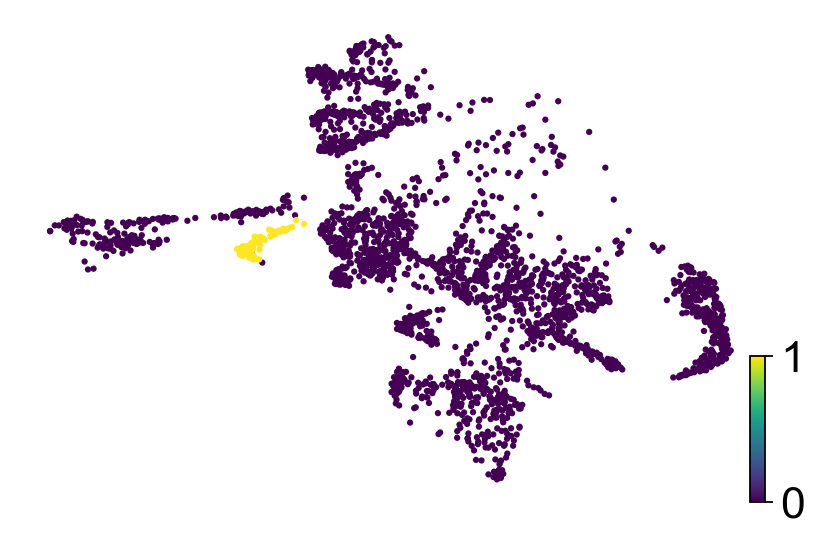

In [39]:
scv.pl.scatter(adata_mos, c=rim_parent_mask, color_map="viridis")

Visualize the ground-truth, and moslin/LineageOT-predicted couplings for this target population. 

In [40]:
methods = ["LineageOT", "W", "GW", "moslin"]

Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting


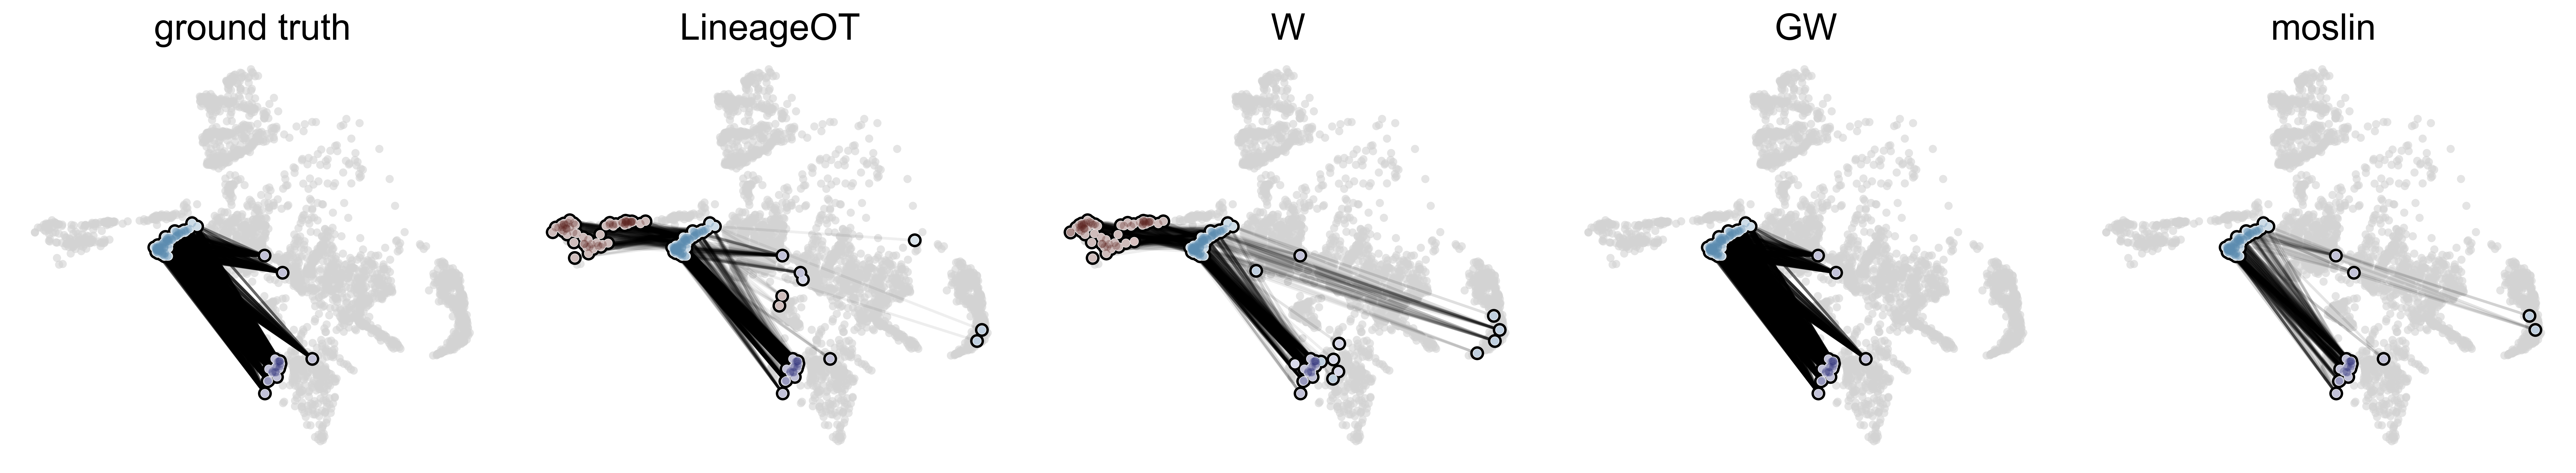

In [41]:
thr = 0.1
alpha_scale = 0.1

# set up the figure with subplots
n_panels = len(methods) + 1
fig, axes = plt.subplots(1, n_panels, figsize=(4 * n_panels, 4), dpi=DPI_SAVE)

common_kwargs = {
    "mask": rim_parent_mask,
    "thr": thr,
    "dot_color": "clusters",
    "alpha_scale": 0.6,
    "early_tp": EARLY_TP,
    "late_tp": LATE_TP,
}

# plot the ground truth coupling
mu.pl.plot_coupling(adata_mos, gt.coupling, ax=axes[0], **common_kwargs)
axes[0].set_title("ground truth")

for i, method in enumerate(methods):
    mu.pl.plot_coupling(adata_mos, results[method]["coupling_matrix"], ax=axes[i + 1], **common_kwargs)
    axes[i + 1].set_title(method)

fig.tight_layout()

if save_figure:
    plt.savefig(FIG_DIR / "umap_couplings.pdf")

### Quantify ancestor and descendant errors over corresponding subpopulations

Quantify the mean descendant error over the `RIM_parent` population, and the mean ancestor error over the `RIM` population. 

In [42]:
rim_mask = adata_mos.obs["clusters"] == "RIM"

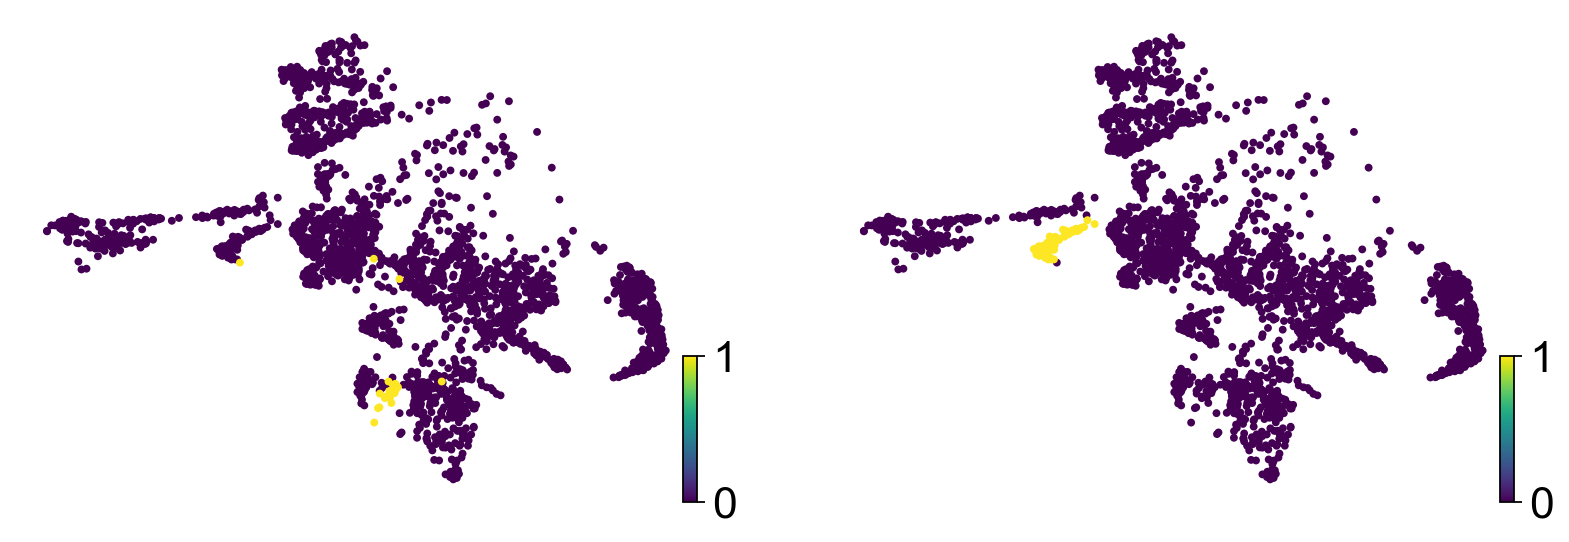

In [43]:
scv.pl.scatter(adata_mos, c=[rim_mask, rim_parent_mask], color_map="viridis", s=50)

Restrict the target-population mask to early cells

In [44]:
# get a mask for early cells
src_mask = adata_mos.obs[TIME_KEY] == EARLY_TP
tgt_mask = adata_mos.obs[TIME_KEY] == LATE_TP

# check that this maches the number of rows in the predicted couplings
assert (
    np.sum(src_mask)
    == results["moslin"]["coupling_matrix"].shape[0]
    == results["LineageOT"]["coupling_matrix"].shape[0]
), "Shape mismatch between prediction and AnnData (source mask)"

assert (
    np.sum(tgt_mask)
    == results["moslin"]["coupling_matrix"].shape[1]
    == results["LineageOT"]["coupling_matrix"].shape[1]
), "Shape mismatch between prediction and AnnData (target mask)"

# subset the target mask to early cells
rim_parent_mask_early = rim_parent_mask[src_mask]
rim_mask_late = rim_mask[tgt_mask]

Visualize the two subsetted masks. 

/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


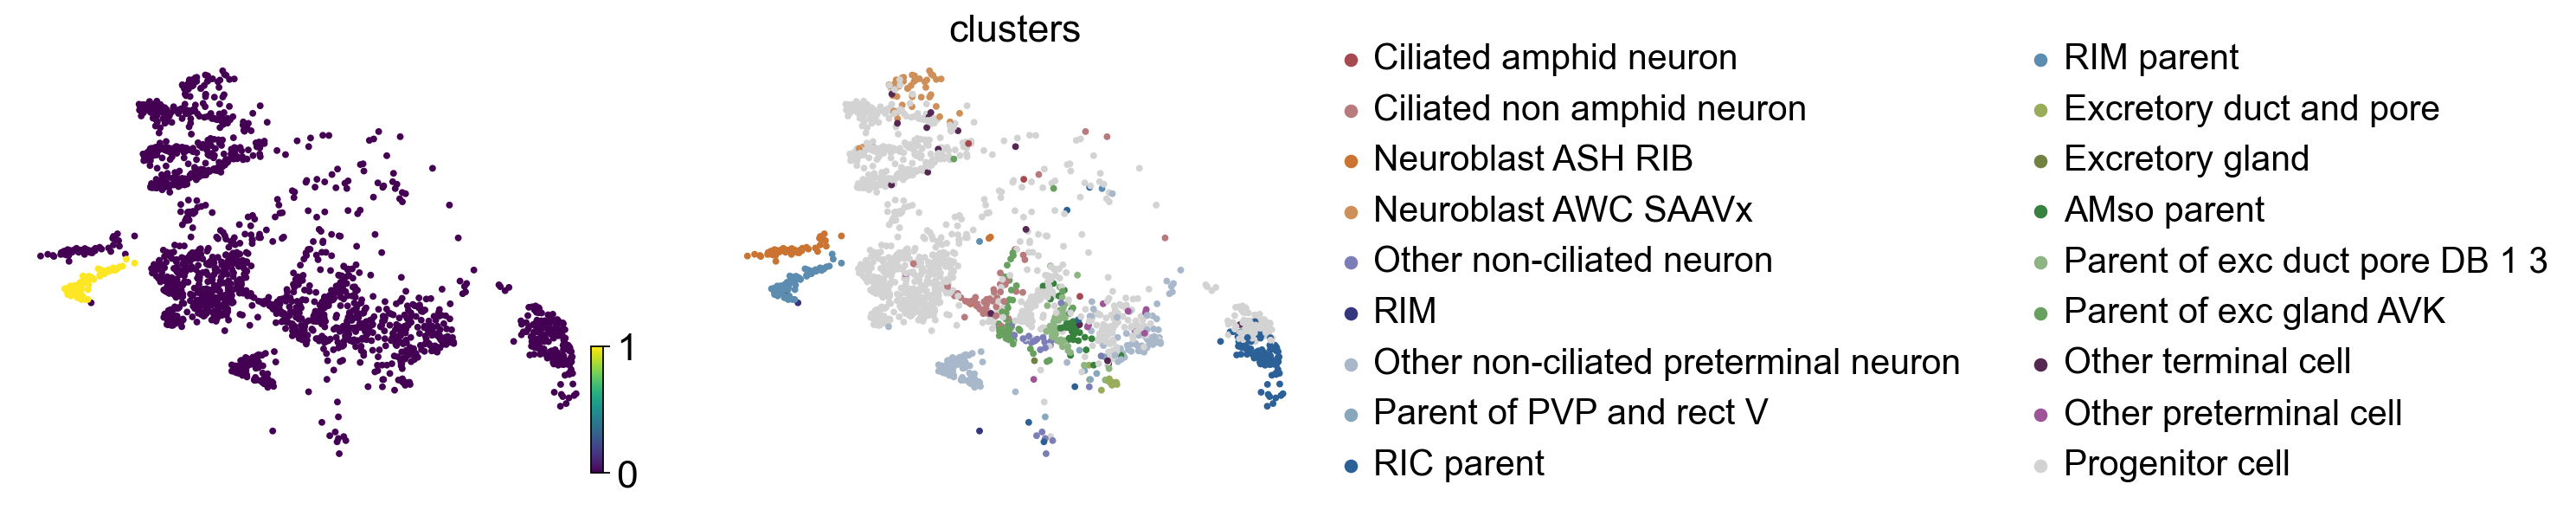

In [45]:
scv.pl.scatter(
    adata_mos[src_mask],
    c=[
        rim_parent_mask_early,
        "clusters",
    ],
    color_map="viridis",
    s=50,
    legend_loc="right",
)

/Users/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


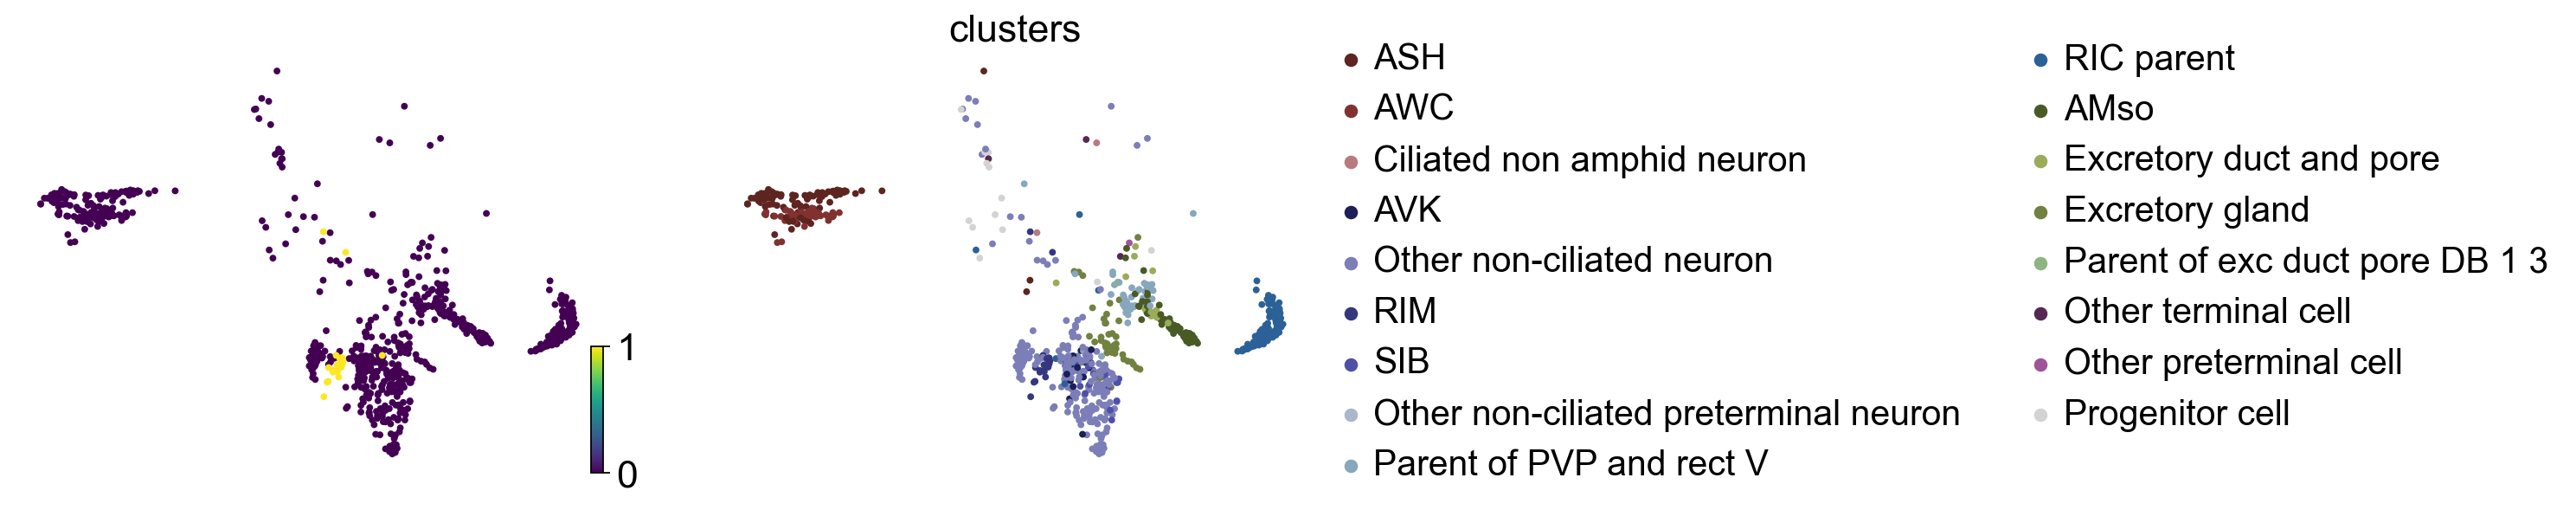

In [46]:
scv.pl.scatter(
    adata_mos[tgt_mask],
    c=[
        rim_mask_late,
        "clusters",
    ],
    color_map="viridis",
    s=50,
    legend_loc="right",
)

Re-compute descendant errors using marginal-scaling. 

In [47]:
ancestor_errors, descendant_errors = {}, {}

# compute the descendant error using an uninformative, independend couplint
anc_error_ind, des_error_ind = mu.ul.compute_errors(gt.ind_coupling, gt, scale_by_marginal=True)

# iterate over all other methods
for method in methods:
    # compute ancestor and descendant errors
    anc_error, des_error = mu.ul.compute_errors(results[method]["coupling_matrix"], gt, scale_by_marginal=True)

    # normalize using the independent coupling
    descendant_errors[method] = np.mean(np.array(des_error)[rim_parent_mask_early]) / np.mean(
        np.array(des_error_ind)[rim_parent_mask_early]
    )

    # normalize using the independent coupling
    ancestor_errors[method] = np.mean(np.array(anc_error)[rim_mask_late]) / np.mean(
        np.array(anc_error_ind)[rim_mask_late]
    )

100%|██████████| 1874/1874 [00:04<00:00, 395.28it/s]


Display these errors. 

In [48]:
ancestor_errors

{'LineageOT': 0.5889724789930966,
 'W': 0.7003682897806517,
 'GW': 0.3783097715151433,
 'moslin': 0.32472834740905293}

In [49]:
descendant_errors

{'LineageOT': 0.7981585082716313,
 'W': 0.8460366537148122,
 'GW': 0.366933345125889,
 'moslin': 0.2615348875802771}

Sanity check, compute the error when using ground truth. 

In [50]:
# compute descendant errors by iterating over all early cells
anc_error, des_error = mu.ul.compute_errors(gt.coupling, gt, scale_by_marginal=True)

100%|██████████| 1874/1874 [00:04<00:00, 451.36it/s]


In [51]:
np.mean(np.array(anc_error)[rim_mask_late]), np.mean(np.array(des_error)[rim_parent_mask_early])

(0.0, 0.0)

As expected, this is zero. 